In [1]:
import cv2
print("Open CV Version :"+str(cv2.__version__))
import tensorflow as tf
print("Tensorflow Version :"+str(tf.__version__))
import matplotlib.pyplot as plt
%matplotlib inline
import time as t
import os
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)


Open CV Version :3.4.4


E:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Tensorflow Version :1.12.0
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [2]:
def show_reconstructed_digits(X, outputs, model_path = None, n_test_digits = 2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

In [3]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

## PCA With Neural Networks

In [4]:
#Constructing our data
import numpy.random as rnd

rnd.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

In [6]:
#The inputs and the outputs
n_input=3
n_hidden=2
n_output=n_input
#Defining the learning rates
learning_rate=0.01

#Defning  or placeholder
X=tf.placeholder(tf.float32,shape=[None,n_input])
hidden=tf.layers.dense(X,n_hidden)
output=tf.layers.dense(hidden,n_output)

#Defining our loss
reconstruction_loss=tf.reduce_mean(tf.square(output-X))

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()

In [7]:
num_epochs=10000
codings=hidden
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
        training_op.run(feed_dict={X:X_train})
        codings_val = codings.eval(feed_dict={X: X_test})

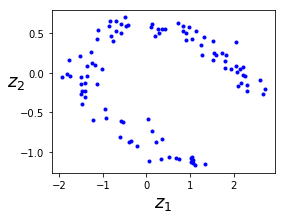

In [8]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings_val[:,0], codings_val[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.show()

## Sparse Autoencoder

In [9]:
tf.reset_default_graph()

#Defining our layers
n_input=28*28
n_hidden=1000
n_output=n_input


In [10]:
def kl_divergence(p,q):
    #Kullback-leibler divergence
    return p * tf.log(p / q) + (1 - p) * tf.log((1 - p) / (1 - q))

#Defining our parameters
learning_rate=0.01
sparsity_target=0.1
sparsity_weight=0.2 #Nor too high or too low to  discard the features

#Defining our placeholders
X=tf.placeholder(tf.float32,shape=[None,n_input])
hidden=tf.layers.dense(X,n_input,activation=tf.nn.sigmoid) #To avoid as kl_divergence returns NaN without sigmoid
output=tf.layers.dense(hidden,n_output)

hidden_mean=tf.reduce_mean(hidden,axis=0)
sparsity_loss=tf.reduce_sum(kl_divergence(sparsity_target,hidden_mean))
reconstruction_loss=tf.reduce_mean(tf.square(output-X)) #Can use sigmoid cross entropy with logits to speed up convergence
loss=reconstruction_loss+sparsity_loss*sparsity_weight

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [11]:
import sys
num_epochs=10
batch_size=1000 #So that our hidden layer mean isn't too low
with tf.Session() as sess:
    init.run()
    for epoch in range(num_epochs):
        n_batches = mnist.train.num_examples
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        reconstruction_loss_val, sparsity_loss_val, loss_val = sess.run([reconstruction_loss, sparsity_loss, loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", reconstruction_loss_val, "\tSparsity loss:", sparsity_loss_val, "\tTotal loss:", loss_val)
        saver.save(sess, "./my_model_sparse_New.ckpt")


0 Train MSE: 0.010883393 	Sparsity loss: 0.040099137 	Total loss: 0.01890322
1 Train MSE: 0.009697816 	Sparsity loss: 0.44235432 	Total loss: 0.098168686
2 Train MSE: 0.009351197 	Sparsity loss: 0.68306094 	Total loss: 0.14596339
3 Train MSE: 0.013492532 	Sparsity loss: 0.15119603 	Total loss: 0.04373174
4 Train MSE: 0.0076811933 	Sparsity loss: 0.07346609 	Total loss: 0.022374412
5 Train MSE: 0.013735458 	Sparsity loss: 0.8951491 	Total loss: 0.19276528
6 Train MSE: 0.012197619 	Sparsity loss: 0.2658172 	Total loss: 0.06536106
79% Train MSE: 0.0089858165 	Sparsity loss: 0.40964198 	Total loss: 0.09091421
8 Train MSE: 0.008364938 	Sparsity loss: 0.08916975 	Total loss: 0.026198888
9 Train MSE: 0.010790004 	Sparsity loss: 0.20512685 	Total loss: 0.051815376


In [26]:
#show_reconstructed_digits(X, outputs, "./my_model_sparse_New.ckpt")

## Stacked Denoisong Autoencoder With/Without Dropouts

In [ ]:
#Stacked denoisng autoencoder can be implemented with or without dropouts.
#We just add random noise to the input and this forcees the autoencoder to
#trivially copying the input to the output. The autoencoder now needs to find
#interesting feaatures without the noise in the input
#the noise can be randomly switched off like the dropout.

### Using Gaussian Noise

In [13]:
tf.reset_default_graph()
#defining the structure of the neural network
n_input=28*28 #The input image size
n_hidden1=300 
n_hidden2=150 #The coding layer
n_hidden3=n_hidden1
n_output=n_input
#Defning our learning rate in the nn
learning_rate=0.01

In [14]:
tf.reset_default_graph()
noisy_level=1.0 #Defining the amount of noise in the data
X=tf.placeholder(tf.float32,[None,n_input])
X_noisy=X+noisy_level*tf.random_normal(tf.shape(X)) #tf.shape(X) correctly displays the shape during the runtime
#as the shape of X is partially defined
hidden1=tf.layers.dense(X_noisy,n_hidden1,activation=tf.nn.relu,name="hidden1")
hidden2=tf.layers.dense(hidden1,n_hidden2,activation=tf.nn.relu,name="hidden2")
hidden3=tf.layers.dense(hidden2,n_hidden3,activation=tf.nn.relu,name="hidden3")
outputs=tf.layers.dense(hidden3,n_output,name="outputs")

reconstruction_loss=tf.reduce_mean(tf.square(outputs-X)) #Mean Squared Error Loss

In [15]:
optimizer=tf.train.AdamOptimizer(learning_rate)
training_op=optimizer.minimize(reconstruction_loss)
init=tf.global_variables_initializer() #the global variable initializer
saver=tf.train.Saver()#The saver

In [16]:
import sys
#Defning the nu of epochs and the batch size
n_epochs=10
batch_size=150
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op,feed_dict={X:X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_stacked_denoising_gaussian_New_One.ckpt")

0 Train MSE: 0.04216841
1 %Train MSE: 0.04327384
2 Train MSE: 0.039360285
3 Train MSE: 0.0414747
4 Train MSE: 0.040011574
5 Train MSE: 0.03911881
6 Train MSE: 0.040927935
7 Train MSE: 0.038915537
8 Train MSE: 0.040026598
9 Train MSE: 0.039881427


INFO:tensorflow:Restoring parameters from ./my_model_stacked_denoising_gaussian_New_One.ckpt


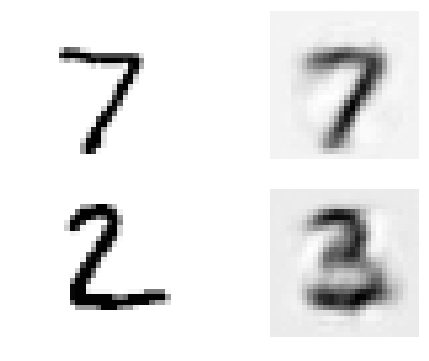

In [17]:
show_reconstructed_digits(X_noisy, outputs, "./my_model_stacked_denoising_gaussian_New_One.ckpt")

### Using Dropout

In [18]:
#The proceedure remains same throughout instead we just introduce a dropout in the 
#code instead of the gausian noise. The rest of the code remains same

In [19]:
tf.reset_default_graph()
#defining the structure of the neural network
n_input=28*28 #The input image size
n_hidden1=300 
n_hidden2=150 #The coding layer
n_hidden3=n_hidden1
n_output=n_input
#Defning our learning rate in the nn
learning_rate=0.01

In [20]:
dropout_rate=0.3
#The is training parameter
training = tf.placeholder_with_default(False, shape=(), name='training')
X=tf.placeholder(tf.float32,shape=[None,n_input],name="X")
X_drop=tf.layers.dropout(X,dropout_rate,training=training)
#as the shape of X is partially defined
hidden1=tf.layers.dense(X_drop,n_hidden1,activation=tf.nn.relu,name="hidden1")
hidden2=tf.layers.dense(hidden1,n_hidden2,activation=tf.nn.relu,name="hidden2")
hidden3=tf.layers.dense(hidden2,n_hidden3,activation=tf.nn.relu,name="hidden3")
outputs=tf.layers.dense(hidden3,n_output,activation=tf.nn.relu,name="output")

reconstruction_loss=tf.reduce_mean(tf.square(outputs-X)) #Mean Squared Error Loss

In [21]:
optimizer=tf.train.AdamOptimizer(learning_rate)
training_op=optimizer.minimize(reconstruction_loss)
init=tf.global_variables_initializer() #the global variable initializer
saver=tf.train.Saver()#The saver

In [22]:
#Defning the nu of epochs and the batch size
n_epochs=10
batch_size=150
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op,feed_dict={X:X_batch,training:True})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_stacked_denoising_gaussian_New.ckpt")

0 Train MSE: 0.027817417
1 Train MSE: 0.023674907
2 Train MSE: 0.023245055
3 Train MSE: 0.019699875
4 Train MSE: 0.021760495
5 Train MSE: 0.021281576
6 Train MSE: 0.02105984
7 Train MSE: 0.018875798
8 Train MSE: 0.020524815
9 Train MSE: 0.021167079


INFO:tensorflow:Restoring parameters from ./my_model_stacked_denoising_gaussian_New.ckpt


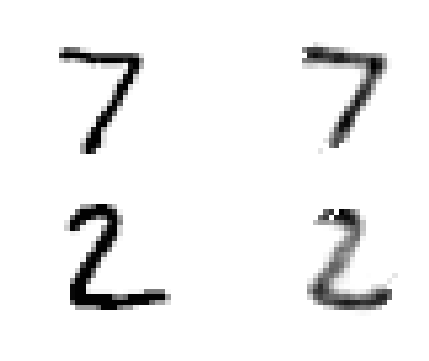

In [23]:
show_reconstructed_digits(X_drop, outputs, "./my_model_stacked_denoising_gaussian_New.ckpt")